<a href="https://colab.research.google.com/github/Wiaz24/LSTM/blob/main/ProjektNN_LSTM_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://gist.github.com/NTT123/4596e5533e573c8ceab2f319ab5d36a2 jslog
!wget https://raw.githubusercontent.com/Wiaz24/LSTM/main/weather_jena_hourly.csv

Cloning into 'jslog'...
remote: Enumerating objects: 18, done.
remote: Total 18 (delta 0), reused 0 (delta 0), pack-reused 18
Unpacking objects: 100% (18/18), 2.90 KiB | 742.00 KiB/s, done.
--2023-05-29 17:50:25--  https://raw.githubusercontent.com/Wiaz24/LSTM/main/weather_jena_hourly.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4403391 (4.2M) [text/plain]
Saving to: ‘weather_jena_hourly.csv’

weather_jena_hourly 100%[===================>]   4.20M  --.-KB/s    in 0.01s   

2023-05-29 17:50:26 (283 MB/s) - ‘weather_jena_hourly.csv’ saved [4403391/4403391]



In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
import torch
import torch.nn as nn
import pandas_datareader as web
import datetime as dt
from datetime import timedelta
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from pathlib import Path
from tqdm.auto import tqdm
import os
import random
import math
import time
from jslog.jslogger import JSLogger
print(torch.__version__)

2.0.1+cu118


### Download or load dataset

In [3]:
DATASETS_PATH = Path("datasets")
DATASETS_PATH.mkdir(parents=True, exist_ok=True)

DATASET_NAME = "weather_jena_hourly.csv"
DATASET_SAVE_PATH = DATASETS_PATH / DATASET_NAME
os.rename(DATASET_NAME, DATASET_SAVE_PATH)

In [4]:
alldata = pd.read_csv(DATASET_SAVE_PATH)

In [5]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70092 entries, 0 to 70091
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   datetime           70092 non-null  object 
 1   temperature        70092 non-null  float64
 2   pressure           70092 non-null  float64
 3   relative_humidity  70092 non-null  float64
 4   vapor_pressure     70092 non-null  float64
 5   wind_speed         70092 non-null  float64
 6   airtight           70092 non-null  float64
dtypes: float64(6), object(1)
memory usage: 3.7+ MB


In [6]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "weather_model.pth"

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [7]:
#alldata = alldata.drop("Unnamed: 0", axis=1)
alldata.index = pd.to_datetime(alldata["datetime"])
alldata = alldata.drop("datetime", axis=1)
alldata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70092 entries, 2009-01-01 00:00:00 to 2016-12-30 11:00:00
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature        70092 non-null  float64
 1   pressure           70092 non-null  float64
 2   relative_humidity  70092 non-null  float64
 3   vapor_pressure     70092 non-null  float64
 4   wind_speed         70092 non-null  float64
 5   airtight           70092 non-null  float64
dtypes: float64(6)
memory usage: 3.7 MB


In [8]:
num_epochs = 10
learning_rate = 0.001
train_perc = 0.7
batch_size = 64

input_size = alldata.shape[1]
hidden_size = 32
num_lstm_layers = 2

seq_length = 72 # 1pkt = 1 godzina
pred_length = 6 # 1pkt = 1 godzina

### Data plot

In [9]:
data = alldata.to_numpy()
data.shape

(70092, 6)

In [10]:
data[0]

array([-8.304000e+00,  9.965280e+02,  9.378000e+01,  3.058000e+00,
        5.200000e-01,  1.309196e+03])

## Dataloading

In [11]:
def sliding_windows(data, seq_length=1):
    x = []
    y = []

    # przykładowo: seq_lenght = 7, pred_length = 3, wtedy:
    for i in range(0, len(data) - seq_length - pred_length, 1):  # dla i = 0:
        _x = data[i:(i+seq_length), :]                      # _x = data[0:7, wszystkie cechy],  potem data[3:10,:]
        _y = data[i+seq_length:i+seq_length+pred_length, 0] # _y = data[7:10, close_price] ,    potem data[10:13,1]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [12]:
sc = MinMaxScaler()
outSc = MinMaxScaler()
outSc.fit_transform(data[:,0].reshape(-1,1))
data = sc.fit_transform(data) #normalizacja danych
x, y = sliding_windows(data, seq_length)  #tworzenie ramek uczących i odpowiedzi

print(f"x.shape = {x.shape}, y.shape = {y.shape}")                

x.shape = (70014, 72, 6), y.shape = (70014, 6)


In [13]:
train_size = int(len(y) * train_perc)
test_size = int((len(y) - train_size)/2)
eval_size = test_size

device = "cuda" if torch.cuda.is_available() else "cpu"

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))
# dataX = dataX.to(device)
# dataY = dataY.to(device) 

dataset = TensorDataset(dataX, dataY)

indices = torch.randperm(len(dataset)-test_size)

### Losowanie próbek do zbioru uczącego i walidacyjnego

In [14]:
train_indices = indices[:train_size]
eval_indices = indices[train_size:train_size+eval_size]
test_indices = torch.arange(train_size+eval_size, dataX.size(0))

In [15]:
train_indices.shape, eval_indices.shape, test_indices.shape

(torch.Size([49009]), torch.Size([10502]), torch.Size([10503]))

### Tworzenie dataloaderów

In [16]:
trainDataLoader = DataLoader(dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(train_indices))
evalDataLoader = DataLoader(dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(eval_indices))

In [17]:
features, labels = next(iter(trainDataLoader))
features.shape, labels.shape, features.device, labels.device

(torch.Size([64, 72, 6]),
 torch.Size([64, 6]),
 device(type='cpu'),
 device(type='cpu'))

## Model

In [18]:
from torch.nn.modules import dropout
class LSTM(nn.Module):

    def __init__(self, pred_length, input_size, hidden_size, num_lstm_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = pred_length
        self.num_lstm_layers = num_lstm_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_lstm_layers, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            num_lstm_layers, x.size(0), self.hidden_size).to(device))

        c_0 = Variable(torch.zeros(
            num_lstm_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        output, _ = self.lstm(x, (h_0, c_0))
        output = self.dropout(output)
        out = output[:, -1, :]
        out = self.fc(out)
        
        return out

## Training

In [19]:
trainlogger = JSLogger('train loss', ['train'])
testlogger = JSLogger('test loss', ['test'])

In [20]:
lstm = LSTM(pred_length, input_size, hidden_size, num_lstm_layers)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
lstm.to(device)

LSTM(
  (lstm): LSTM(6, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=32, out_features=6, bias=True)
)

In [21]:
len(trainDataLoader)

766

In [35]:
if MODEL_SAVE_PATH.is_file(): 
  lstm.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
else:
  trainlogger.show()
  testlogger.show()
  # Train the model
  for epoch in tqdm(range(num_epochs)):
      #uczenie modelu
      lstm.train()
      n = 0
      train_loss = 0
      for inputs, labels in trainDataLoader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          n+=1
          optimizer.zero_grad()
          outputs = lstm(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          train_loss = loss.item()
          trainlogger.log(n+epoch*len(trainDataLoader), {'train': train_loss})
      # ewaluacja modelu
      lstm.eval()
      m = 0
      eval_loss=0
      with torch.no_grad():
          for inputs, labels in evalDataLoader:
              inputs = inputs.to(device)
              labels = labels.to(device)
              outputs = lstm(inputs)
              loss = criterion(outputs, labels)
              m+=1
              eval_loss = loss.item()
              testlogger.log(m+epoch*len(evalDataLoader), {'test': eval_loss})
      # wykres funkcji straty dla zbioru treningowego i ewaluacyjnego
      #logger.log(epoch, {'train': train_loss/n, 'test': eval_loss/m})

# Testing

In [36]:
lstm.eval()
answers = dataY[test_indices].cpu()
with torch.inference_mode():
    predictions = lstm(dataX[test_indices].to(device)).cpu()

In [37]:
loss = criterion(predictions.cpu(), answers)
print(f"Loss = {loss}")

Loss = 0.0006744171842001379


In [39]:
predictions = outSc.inverse_transform(predictions)
answers = outSc.inverse_transform(answers)

In [40]:
predictions = predictions[:,-1]
answers = answers[:,-1]

In [41]:
predictions.shape, answers.shape

((10503,), (10503,))

In [42]:
_dates = pd.date_range(start=alldata.index[test_indices.numpy()][0], end=alldata.index[test_indices.numpy()][-1], periods=alldata.index[test_indices.numpy()].size)
print(_dates.size)

10503


In [43]:
df = pd.DataFrame({"date": _dates, "Original data": answers, "Predictions": predictions})
df.set_index('date', inplace=True)

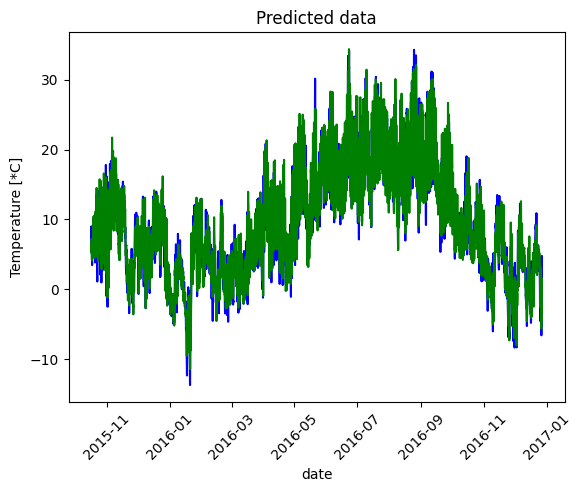

In [44]:
plt.plot(df['Original data'], label="Original data", c='b')
plt.plot(df['Predictions'], label="Predictions", c='g')
plt.xticks(rotation=45)
plt.xlabel("date")
plt.ylabel("Temperature [*C]")
plt.title("Predicted data")
plt.show()

<ipython-input-45-325ffaa3e3da>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
<ipython-input-45-325ffaa3e3da>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,1].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
<ipython-input-45-325ffaa3e3da>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
<ipython-input-45-325ffaa3e3da>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,1].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)


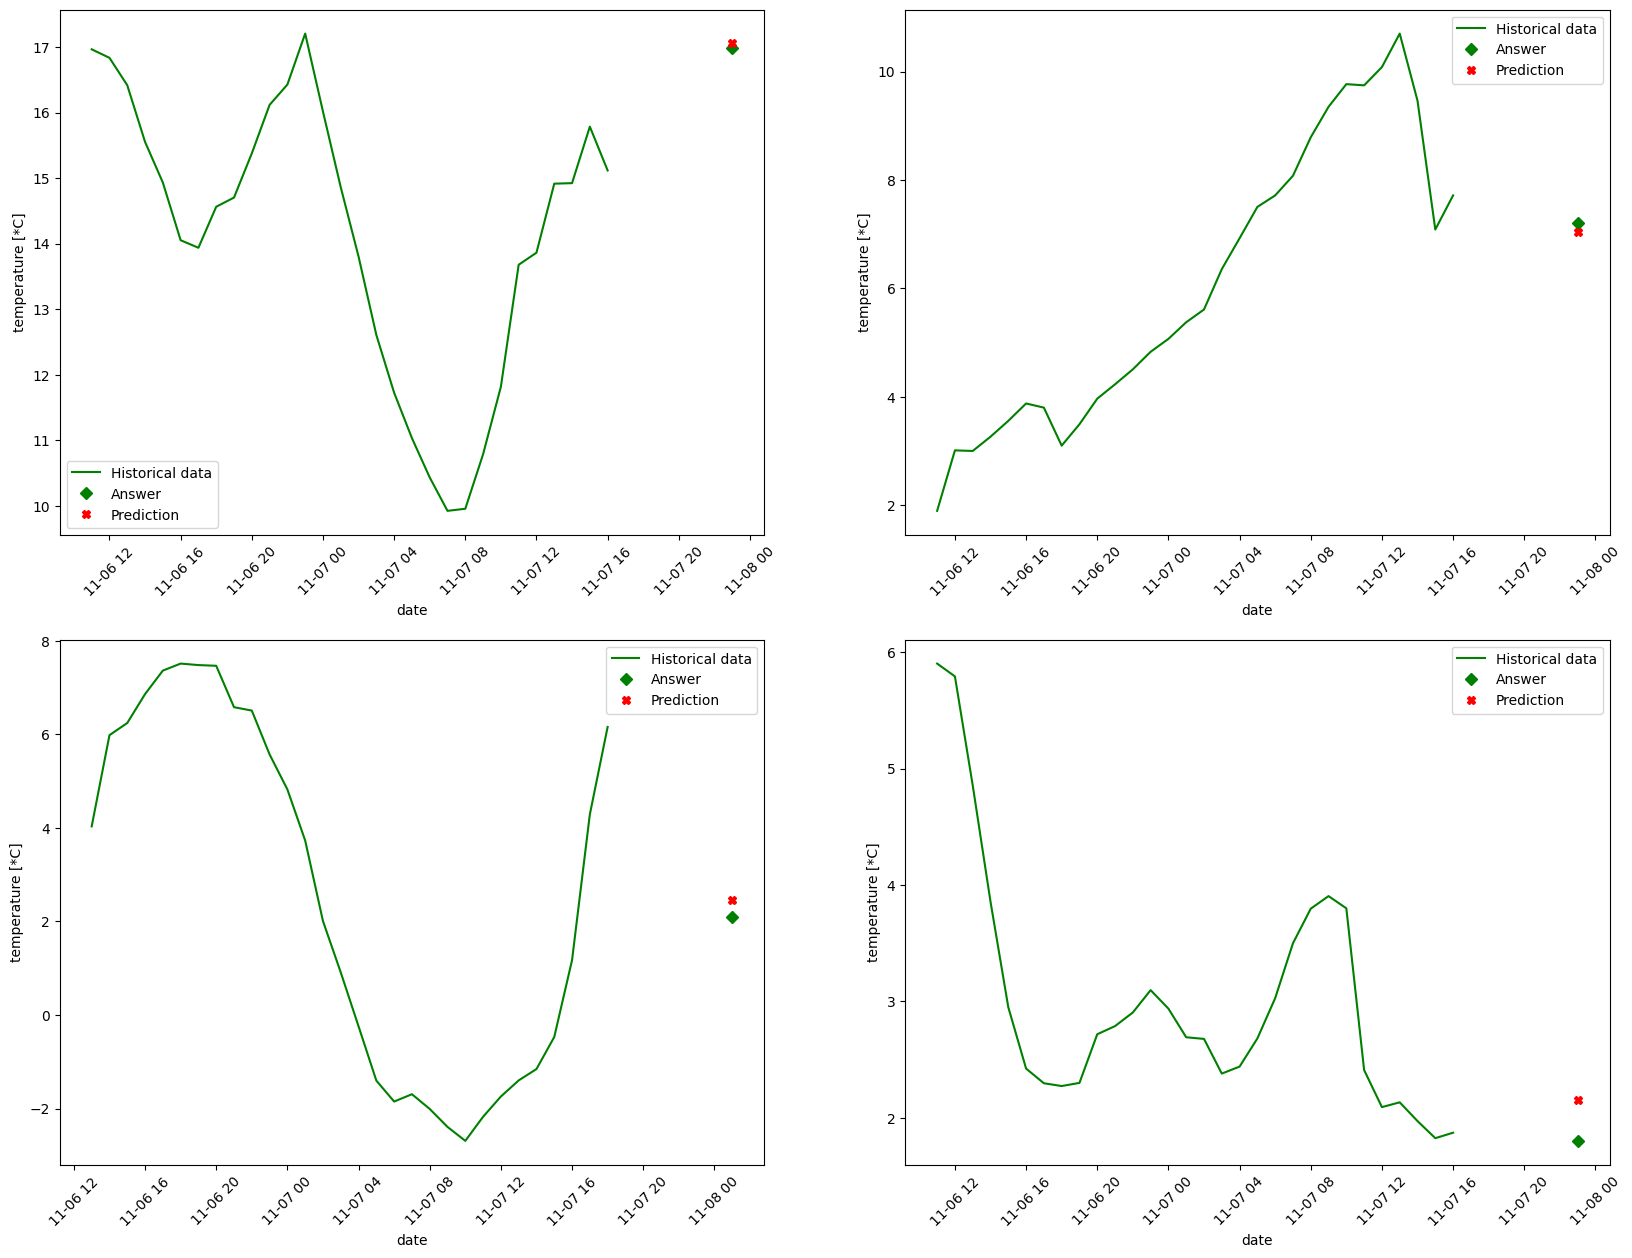

In [45]:
from matplotlib.pyplot import figure

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

history_start = 500
history_lenght = 30
axes[0,0].plot(df.index[history_start:history_start+history_lenght], df["Original data"][history_start:history_start+history_lenght], label="Historical data", c='g')
axes[0,0].plot(df.index[history_start+history_lenght+pred_length], df["Original data"][history_start+history_lenght+pred_length], "gD", label="Answer")
axes[0,0].plot(df.index[history_start+history_lenght+pred_length], df["Predictions"][history_start+history_lenght+pred_length], "rX", label="Prediction")
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
axes[0,0].set_xlabel("date")
axes[0,0].set_ylabel("temperature [*C]")
axes[0,0].legend()

history_start = 1000
axes[0,1].plot(df.index[history_start:history_start+history_lenght], df["Original data"][history_start:history_start+history_lenght], label="Historical data", c='g')
axes[0,1].plot(df.index[history_start+history_lenght+pred_length], df["Original data"][history_start+history_lenght+pred_length], "gD", label="Answer")
axes[0,1].plot(df.index[history_start+history_lenght+pred_length], df["Predictions"][history_start+history_lenght+pred_length], "rX", label="Prediction")
axes[0,1].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
axes[0,1].set_xlabel("date")
axes[0,1].set_ylabel("temperature [*C]")
axes[0,1].legend()

history_start = 1250
axes[1,0].plot(df.index[history_start:history_start+history_lenght], df["Original data"][history_start:history_start+history_lenght], label="Historical data", c='g')
axes[1,0].plot(df.index[history_start+history_lenght+pred_length], df["Original data"][history_start+history_lenght+pred_length], "gD", label="Answer")
axes[1,0].plot(df.index[history_start+history_lenght+pred_length], df["Predictions"][history_start+history_lenght+pred_length], "rX", label="Prediction")
axes[1,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
axes[1,0].set_xlabel("date")
axes[1,0].set_ylabel("temperature [*C]")
axes[1,0].legend()

history_start = 2600
axes[1,1].plot(df.index[history_start:history_start+history_lenght], df["Original data"][history_start:history_start+history_lenght], label="Historical data", c='g')
axes[1,1].plot(df.index[history_start+history_lenght+pred_length], df["Original data"][history_start+history_lenght+pred_length], "gD", label="Answer")
axes[1,1].plot(df.index[history_start+history_lenght+pred_length], df["Predictions"][history_start+history_lenght+pred_length], "rX", label="Prediction")
axes[1,1].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
axes[1,1].set_xlabel("date")
axes[1,1].set_ylabel("temperature [*C]")
axes[1,1].legend()

plt.show()

In [34]:
torch.save(obj=lstm.state_dict(),
           f=MODEL_SAVE_PATH)